# Task 1

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
df = pd.read_csv("/Users/zoezhou/Desktop/UCHICAGO FALL2018/Real-time Intelligent/streaming.csv")
df.head(5)

/Users/zoezhou/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Seconds,Alpha,Red,Green,Blue
0,1,-26,-155,-285,1
1,2,-4,0,-48,-104
2,3,-15,-60,-165,-345
3,4,23,115,299,161
4,5,-5,-38,2,-28


# Task 2

For each color, calculate the R-squared with a rolling window of 500 seconds. You will do a regression linear between one given color and Alpha on a 500 second- vector. Therefore, during the first 500 seconds, you will not have any regression linear data. The chart below starts at 0 (being +500 seconds) and represents the R-squared for the 3 colors.

In [2]:

red,green,blue=[],[],[]
for i in range(1,len(df["Alpha"])+1):
    window=df.loc[i-500:i]
    A=window.Alpha
    B=window.Red
    model=sm.OLS(B,A)
    model_fit=model.fit()
    red.append(model_fit.rsquared)

print(red[0:4])


[0.976878612716763, 0.9594497105947488, 0.9714152577235814, 0.9691510853246144]


In [3]:

for i in range(1,len(df["Alpha"])+1):
    window=df.loc[i-500:i]
    A=window.Alpha
    B=window.Green
    model=sm.OLS(B,A)
    model_fit=model.fit()
    green.append(model_fit.rsquared)

print(green[0:4])

[0.9997982079118691, 0.9998474912983196, 0.9931380496850764, 0.9750886250733183]


In [4]:

for i in range(1,len(df["Alpha"])+1):
    window=df.loc[i-500:i]
    A=window.Alpha
    B=window.Blue
    model=sm.OLS(B,A)
    model_fit=model.fit()
    blue.append(model_fit.rsquared)

print(blue[0:4])

[0.020319653125753123, 0.2601032658482987, 0.3813637892919367, 0.384359124384392]


In [5]:
r_2=pd.DataFrame({"Red":red,"Green":green,"Blue":blue})

In [6]:
print(r_2.head(5))

       Blue     Green       Red
0  0.020320  0.999798  0.976879
1  0.260103  0.999847  0.959450
2  0.381364  0.993138  0.971415
3  0.384359  0.975089  0.969151
4  0.470089  0.975571  0.973004


# Task 3

Find the approximate seconds you encounter problems of correlation between the colors and the alpha.

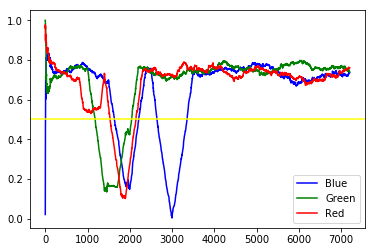

In [7]:
r_2.plot(color=["Blue","Green","Red"])
plt.axhline(y=0.5, color='yellow')

#Comments
From the graph above, I defined bad correlation when R-square is below 0.5. For the red line, the bad correlation is  roughly between 1500-2200. For the green line, the bad correlation is 1100 to 2100. And for the blue line, the bad correlation is [1600,2200] and [2600,3400].

In [ ]:
#Task 4

The goal is to detect bad correlation in real time. Therefore you need to parallelize the linear regression for the three colors to be faster. You should find the same results as the task 3.

In [8]:
import threading

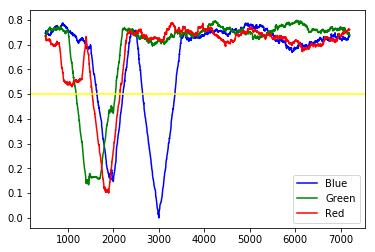

In [9]:
def ParallelRegression(color_index, df, rst): 
    colors=["Blue","Green","Red"]
    color = colors[color_index]
    for i in range(1, len(df)+1):
        if i < 500: 
            continue
        window = df.loc[i-500:i]
        Y = window.Alpha
        X = window.loc[:, color]
        
        model = sm.OLS(Y, X)
        model_fit = model.fit()
        rst.at[i, color] = model_fit.rsquared

rsquare=pd.DataFrame(index=[i for i in range(len(red))],columns=["Blue","Green","Red"])
threads = []
totalThreads = 3
for threadnum in range(totalThreads):
    t = threading.Thread(target=ParallelRegression, args=(threadnum, df, rsquare,))
    threads.append(t)
    t.start()

for threadnum in range(totalThreads): 
    threads[threadnum].join()
rsquare.plot(color = ["Blue","Green","Red"])
plt.axhline(y=0.5, color='yellow')

# Task 5


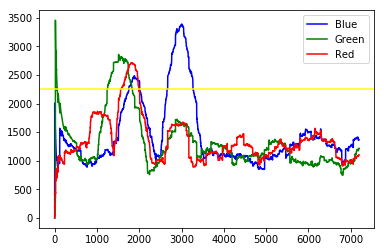

In [10]:
def ParallelRegression_CI(color_index, df, rst): 
    color = colors[color_index]
    for i in range(len(df["Alpha"])):
        
        window = df.loc[i-500:i]
        y = window.Alpha
        X = window.loc[:, color]
        model = sm.OLS(y, X)
        model_fit = model.fit()
        y_hat = model_fit.predict(X)
        sse = (y - y_hat) ** 2
        mean_sse = np.mean(sse)
        sd_sse = np.var(sse)**0.5
        interval = 2 * (mean_sse + 1.96 * sd_sse)
        rst.at[i, color] = interval
        
colors=["Blue","Green","Red"]
confi_int = pd.DataFrame(index=df.index, columns= colors)

threads = []
totalThreads = 3
for thread_num in range(totalThreads):
    t = threading.Thread(target=ParallelRegression_CI, args=(thread_num, df, confi_int,))
    threads.append(t)
    t.start()
for thread_num in range(totalThreads): 
    threads[thread_num].join()
    
confi_int.plot(color=colors)
plt.axhline(y=2250, color='yellow')